<h1>LSTM + CNN + MLPNN model</h1>

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #only show errors (hide INFO and WARNING)

import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt

random.seed(1234)   
np.random.seed(1234)


<h3>Helper functions to plot loss/accuracy, and build/train/test models.</h3>

In [2]:
def plot_loss_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

def plot_accuracy_history(history):
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['accuracy'] + 1)))
  plt.plot(history['accuracy'], label="training", marker='o')
  plt.plot(history['val_accuracy'], label="validation", marker='o')
  plt.legend()
  plt.show()

In [3]:
def build_model(sample_size, num_of_features,
                dense_layers_unit_array=[], learningRate=0.001,
                activation="relu", isBatchNormalized=False, dropOutRate=0,
                startWithBatchNormalized=False,optimizer="Adam",
                conv_layers_filters_array=[],conv_kernel_size_array=[],conv_strides_array=[],
                lstm_layers_unit_array=[]
               ):
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    
    strategy = tf.distribute.MirroredStrategy(devices=None)
    print('Number of GPU/CPU: {}'.format(strategy.num_replicas_in_sync))
    
    print("num_of_dense_layers:",len(dense_layers_unit_array))
    
    for i, dense_layer_unit in enumerate(dense_layers_unit_array):       
        print("dense_layer["+str(i)+"]; unit:"+str(dense_layer_unit))   
        
    print("num_of_lstm_layers:",len(lstm_layers_unit_array))    
    for i, lstm_layer_unit in enumerate(lstm_layers_unit_array):       
        print("lstm_layer_unit["+str(i)+"]; unit:"+str(lstm_layer_unit))       
        
    print("num_of_conv_layers:",len(conv_layers_filters_array))    
    for i, conv_layer_filters in enumerate(conv_layers_filters_array):       
        print("conv_layer_filters["+str(i)+"]; unit:"+str(conv_layer_filters))  
        print("conv_kernel["+str(i)+"]; unit:"+str(conv_kernel_size_array[i]))
        print("conv_strides["+str(i)+"]; unit:"+str(conv_strides_array[i]))
       
    print("learningRate:",learningRate)
    print("isBatchNormalized:",isBatchNormalized,"; dropOutRate:",dropOutRate)
    
    startWithBatchNormalized = startWithBatchNormalized or optimizer == "SGD"
    print("startWithBatchNormalized:",startWithBatchNormalized)
    print("optimizer:",optimizer,"; activation:",activation)
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)     
    np.random.seed(1234)
    random.seed(1234)
    
    with strategy.scope():   
        model = Sequential() 
        
        if startWithBatchNormalized:
            model.add(BatchNormalization())
         
        # Add LSTM layers
        for i, lstm_layer_unit in enumerate(lstm_layers_unit_array):    
            model.add(LSTM(lstm_layer_unit, return_sequences=True))
        
        # Add Conv layers
        for i, conv_layer_filters in enumerate(conv_layers_filters_array):    
            model.add(tf.keras.layers.Conv1D(
            filters=conv_layer_filters,                
            kernel_size=conv_kernel_size_array[i],
            strides=conv_strides_array[i],
            padding='same',
            data_format='channels_last',
            name='conv_'+str(i),
            activation='relu'))
        
            model.add(tf.keras.layers.MaxPool1D(
                pool_size=2,
                name='pool_'+str(i))) 

        if len(conv_layers_filters_array) > 0:    
            model.add(Flatten()) 
        
        # Add Dense layers
        for i, dense_layer_unit in enumerate(dense_layers_unit_array):
            model.add(tf.keras.layers.Dense(
                units=dense_layer_unit,
                name='fc_'+str(i), 
                activation=activation))
            if isBatchNormalized:
                model.add(BatchNormalization())
            if dropOutRate > 0:
                model.add(Dropout(dropOutRate))
                
        model.add(Dense(4))
        model.add(Activation('softmax'))   

        if len(conv_layers_filters_array) == 0 and len(dense_layers_unit_array) > 0 : 
            model.build(input_shape=(None, number_of_features))
        else:
            model.build(input_shape=(None, sample_size, num_of_features)) 

        if optimizer=="Adam":
            opt = keras.optimizers.Adam(learning_rate=learningRate)
        elif optimizer=="SGD":
            opt = keras.optimizers.SGD(learning_rate=learningRate)
        else:
            opt = keras.optimizers.Adam(learning_rate=learningRate)    
        

        model.compile(optimizer=opt,
                      loss=['categorical_crossentropy'],
                      metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])    
    
    return model
    

In [4]:
def train_and_test_model(sample_size, num_of_features,
                         train_dataset, validate_dataset, x_train, test_dataset,
                         save_to, epoch = 2,
                         dense_layers_unit_array=[],
                         patience=10, epoch_denominator=10.,
                         isConstantLearningRate=False, learningRate=0.001,
                         activation="relu", isBatchNormalized=False,dropOutRate=0,
                         startWithBatchNormalized=False,optimizer="Adam",
                         conv_layers_filters_array=[],conv_kernel_size_array=[],conv_strides_array=[],
                         lstm_layers_unit_array=[]
                        ):
    
    print("epoch:",epoch, "; epoch_denominator:",epoch_denominator) 
    print("patience:",patience,"; isConstantLearningRate:", isConstantLearningRate) 
    
    model = build_model(sample_size, num_of_features,
                        dense_layers_unit_array=dense_layers_unit_array, learningRate=learningRate,
                        activation=activation, isBatchNormalized=isBatchNormalized, dropOutRate=dropOutRate,
                        startWithBatchNormalized=startWithBatchNormalized,optimizer=optimizer,
                        conv_layers_filters_array=conv_layers_filters_array,
                        conv_kernel_size_array=conv_kernel_size_array,
                        conv_strides_array=conv_strides_array,
                        lstm_layers_unit_array=lstm_layers_unit_array
                       )

    model.summary()
    tf.keras.utils.plot_model(model)  
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

    if isConstantLearningRate:  
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learningRate)        
    else:  
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learningRate * np.exp(-epoch / epoch_denominator))

    history = model.fit(train_dataset,
                        epochs=epoch,
                        validation_data=validate_dataset,
                        shuffle=True,
                        callbacks=[es,lr_schedule])

    history_data = pd.DataFrame(history.history)
    plot_loss_history(history_data)
    plot_accuracy_history(history_data)

    # test model
    test_results = model.evaluate(test_dataset)
    print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

    # show classification report
    y_predict = np.array(model.predict(test_dataset))
    y_predict = to_categorical(np.argmax(y_predict, axis=1), 4)
    print(classification_report(y_test, y_predict))
    
    print("Confusion matrix")
    print(confusion_matrix(y_test.values.argmax(axis=1), np.argmax(y_predict, axis=1)))
    


In [5]:
dataset = pd.read_csv('csv/out_gameemo_time_domain_simple.csv',  sep=',')

print('Shape of data: ', dataset.shape)

Shape of data:  (4284224, 15)


In [6]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

init_df = dataset.copy()

#HA_PV = high arousal, positive valence
#HA_NV = high arousal, negative valence
#LA_NV = low arousal, negative valence
#LA_PV = low arousal, positive valance
label_map = {1:"HA_PV", 2:"HA_NV", 3:"LA_NV", 4:"LA_PV"}

init_df["Label"] = init_df["Label"].map(label_map)


features = init_df.iloc[:, :-1]
label = init_df.iloc[:, -1:]

print('Shape of data: ', init_df.shape)
print('features.shape: ', features.shape)
print('label.shape: ', label.shape)

#######

y = label.to_numpy()
X = features.to_numpy()

# 38252 is the max sample size, data collected for one participant. Can choose smaller sample size that can
# divide 38252.
# 38252 can be divided by 73 or 131, 524
sample_size = int(38252/73)  
num_of_features = 14

train_dataset_percentage = 0.6

print("sample_size:",sample_size)
print("num_of_features:",num_of_features)

print("number of records:",X.shape[0])
total_samples_count = int(X.shape[0]/sample_size)

print("total_samples_count:", total_samples_count)


train_sample_count = int(total_samples_count * train_dataset_percentage)
validate_sample_count = int((total_samples_count - train_sample_count) * 0.5) # half of 40% = 20%
test_sample_count = total_samples_count - train_sample_count - validate_sample_count

train_size = int(train_sample_count * sample_size)
validate_size = int(validate_sample_count * sample_size)
test_size = int(test_sample_count * sample_size)

print("train size:", train_size)
print("validate size:", validate_size)
print("test size:", test_size)

X_train, X_validate, X_test = X[:train_size], X[train_size:train_size+validate_size], X[-test_size:]
y_train, y_validate, y_test = y[:train_size], y[train_size:train_size+validate_size], y[-test_size:]

X_train = X_train.reshape((train_sample_count,sample_size,num_of_features))
X_validate = X_validate.reshape((validate_sample_count,sample_size,num_of_features))
X_test = X_test.reshape((test_sample_count,sample_size,num_of_features))

print("X_train.shape after reshape:",X_train.shape)
print("X_validate.shape after reshape:",X_validate.shape)
print("X_test.shape after reshape:",X_test.shape)

#collapse y_train and y_test to the same X sample counts instead

y_train_collapsed = np.array([])
for i in range(len(y_train)):
    if (i % sample_size == 0):
        y_train_collapsed = np.append(y_train_collapsed, (y_train[i]))
        
print("y_train_collapsed shape:",y_train_collapsed.shape)        

y_validate_collapsed = np.array([])
for i in range(len(y_validate)):
    if (i % sample_size == 0):
        y_validate_collapsed = np.append(y_validate_collapsed, (y_validate[i]))
        
print("y_validate_collapsed shape:",y_validate_collapsed.shape)

y_test_collapsed = np.array([])
for i in range(len(y_test)):
    if (i % sample_size == 0):
        y_test_collapsed = np.append(y_test_collapsed, (y_test[i]))
        
print("y_test_collapsed shape:",y_test_collapsed.shape)    


y_train = pd.get_dummies(y_train_collapsed)
y_validate = pd.get_dummies(y_validate_collapsed)
y_test = pd.get_dummies(y_test_collapsed)

print("y_train.shape:", y_train.shape)
print("y_validate.shape:", y_validate.shape)
print("y_test.shape:", y_test.shape)

print("y_train:")
print(y_train[:5])

#######

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validate_dataset = tf.data.Dataset.from_tensor_slices((X_validate, y_validate))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_dataset.with_options(options)
validate_dataset.with_options(options)
test_dataset.with_options(options)

        
batch_size = 30
train_dataset = train_dataset.batch(batch_size)
validate_dataset = validate_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)


Shape of data:  (4284224, 15)
features.shape:  (4284224, 14)
label.shape:  (4284224, 1)
sample_size: 524
num_of_features: 14
number of records: 4284224
total_samples_count: 8176
train size: 2570220
validate size: 856740
test size: 857264
X_train.shape after reshape: (4905, 524, 14)
X_validate.shape after reshape: (1635, 524, 14)
X_test.shape after reshape: (1636, 524, 14)
y_train_collapsed shape: (4905,)
y_validate_collapsed shape: (1635,)
y_test_collapsed shape: (1636,)
y_train.shape: (4905, 4)
y_validate.shape: (1635, 4)
y_test.shape: (1636, 4)
y_train:
   HA_NV  HA_PV  LA_NV  LA_PV
0      1      0      0      0
1      1      0      0      0
2      1      0      0      0
3      1      0      0      0
4      1      0      0      0


<h3>Manual runs to get a feel of the hyperparameters</h3>

Using the best setup on features dataset which has 89.63% accuracy. Results: when tested on raw dataset it only has 26.04% accuracy.

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_lstm_layers: 1
lstm_layer_unit[0]; unit:256
num_of_conv_layers: 3
conv_layer_filters[0]; unit:100
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
conv_layer_filters[1]; unit:100
conv_kernel[1]; unit:3
conv_strides[1]; unit:1
conv_layer_filters[2]; unit:100
conv_kernel[2]; unit:3
conv_strides[2]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/d

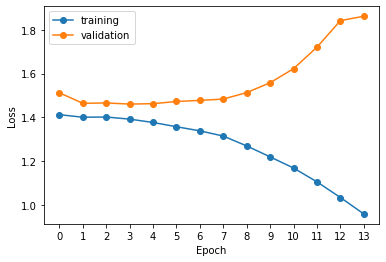

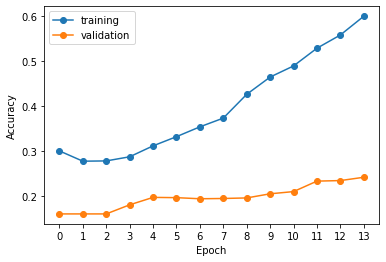

55/55 [==============================] - 1s 16ms/step - loss: 1.8205 - accuracy: 0.2604 - precision: 0.2717 - recall: 0.1913

Test Acc. 26.04%
              precision    recall  f1-score   support

           0       0.40      0.02      0.04       438
           1       0.28      0.81      0.42       395
           2       0.15      0.13      0.14       438
           3       0.49      0.10      0.17       365

   micro avg       0.26      0.26      0.26      1636
   macro avg       0.33      0.27      0.19      1636
weighted avg       0.32      0.26      0.19      1636
 samples avg       0.26      0.26      0.26      1636

Confusion matrix
[[ 10 295 116  17]
 [  2 321  63   9]
 [  6 362  58  12]
 [  7 165 156  37]]


In [7]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, test_dataset, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[100,100,100],
                     conv_kernel_size_array=[3,3,3],
                     conv_strides_array=[1,1,1],
                     lstm_layers_unit_array=[256]
                    )

<h3>Conclusion</h3>

Using the best setup on features dataset which has 89.63% accuracy. Results: when tested on raw dataset it only has 26.04% accuracy.


